In [10]:
import cupy as cp
import numpy as np
from sklearn.datasets import make_moons 
from sklearn.preprocessing import OneHotEncoder
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles,make_moons

from scipy.sparse.linalg import eigsh

synthetic data

In [2]:
X_train, y = make_circles(n_samples=1000,factor=.3, noise=.05)

In [ ]:
#X_train, y = make_moons(n_samples=400, noise=.05, random_state=0)

In [30]:
gamma=10#parameter for rbf kernel
degree=2# parameter of polynomial kernel
def KK(kernel_,X):
  #kernel function
        if kernel_=="poly":
           return cp.power(cp.matmul(X,X.T)+1,degree)
        if kernel_== "rbf" :
           aa=cp.diag(cp.matmul(X,X.T)).reshape(1,-1)+ cp.diag(cp.matmul(X,X.T)).reshape(-1,1) -2*cp.matmul(X,X.T)
           return cp.exp(-gamma*aa)
from sklearn.mixture import GaussianMixture as GMM
        
class GaussianMixture:

    def __init__(self, n_components= 2, max_iter: int = 100, epsilon=1e-10,kernel="rbf",d_phi=None,initial="random"):
       #initial ： methods of initialization for class label assignment
        
        self.n_components = n_components

        self.a = None

        self.w = None

        self.K_tilde = None
        self.K_tilde_pie = None
        self.epsilon=epsilon
        self.kernel=kernel
        self.d_phi=d_phi
        self.max_iter = max_iter
        self.initial=initial
        self.predict=None
         
    def fit(self, X_train,pp=None):

        # 获取一些必要的数据信息
        
        n_samples, n_feature = X_train.shape
        r=n_samples
        #初始化 p
        #yy=np.random.uniform(0,1,400).reshape(-1,1)
        #io=1-yy
        #yy=np.concatenate((yy,io),1)
        if self.initial == "random":
            p=np.random.binomial(1,0.5,n_samples)
        if self.initial=="gmm":
            gmm = GMM(n_components=self.n_components,n_init=1).fit(cp.asnumpy(X_train))
            p = gmm.predict(cp.asnumpy(X_train))  
        if self.initial=="feed":
            p=pp
        yy = (OneHotEncoder().fit_transform(p.reshape(-1,1)).toarray()+0.0001)/1.0002

        P_t= cp.asarray(yy)##n_samples*n_components
        K=KK(self.kernel,X_train)#k(xi,xj)

        # 初始化一些必要的参数：均值，协方差，权重
        for iter in range(self.max_iter):
            P_t_old=cp.copy(P_t)
            self.a = cp.mean(P_t,0)
            w=cp.sqrt(cp.divide(P_t,cp.sum(P_t,0).reshape(1,-1)))#n_samples*n_components
    
            self.K_tilde=[]#K_tilede[l] centered w_ilwj_lk(xi,xj)
            self.K_tilde_pie=[]#K_tilede_pie[l] centered wj_lk(xi,xj)
            G=[]#G_l(phi(xi)|theta)
     
 
            lamda_l=[]
            beta_l=[]
            rho=0
            for l in range(2):
                w_l=w[:,l]#t
                K_t_l=(cp.multiply(cp.multiply(w_l.reshape(-1,1),K),w_l.reshape(1,-1)))
  
                K_t_pie_l=cp.multiply(w_l.reshape(1,-1),K)
                W_l=cp.outer(w_l,w_l)#t

                W_l_pie=cp.outer(cp.ones_like(w_l),w_l)
                self.K_tilde.append(K_t_l-cp.matmul(W_l,K_t_l)-cp.matmul(K_t_l,W_l)+cp.matmul(W_l,cp.matmul(K_t_l,W_l)))
                self.K_tilde_pie.append(K_t_pie_l-cp.matmul(W_l_pie,K_t_l)-cp.matmul(K_t_pie_l,W_l)+cp.matmul(W_l_pie,cp.matmul(K_t_l,W_l)))  
   
                e,v=cp.linalg.eigh(self.K_tilde[l])
                lamda_l.append(e[e>1e-5])
                beta_l.append(cp.transpose(v[e>1e-5]))
                self.d_phi[l]=lamda_l[l].shape[0]
                #ll=list(-np.array(range(1,self.d_phi[l]+1)))
                #lamda_l.append(e[[ll]])
                #beta_l.append(cp.transpose(v[[ll]]))
                #print(lamda_l[l])
                rho+=(cp.trace(self.K_tilde[l])-cp.sum(lamda_l[l]))*self.a[l]
                #print(1)
            
            rho=rho/cp.matmul((r-cp.array(self.d_phi)),self.a)
            #print(rho)
            for l in range(2):   
                w_l=w[:,l]#t
                y_e=(cp.matmul(self.K_tilde_pie[l],beta_l[l]))#d_phi*n_samples
 
                epsl=cp.divide(cp.diag(self.K_tilde[l]),cp.power(w_l,2))-cp.sum(cp.power(y_e,2),1)# 为什么是负的？？？？？
                
                logpart=-0.5*cp.sum(cp.divide(cp.power(y_e,2),lamda_l[l].reshape(1,-1)),1)-(0.5/rho)*(epsl)
                #print(logpart)
                logC=0.5*cp.sum(cp.log(lamda_l[l]))+0.5*(r-self.d_phi[l])*cp.log(rho)+math.log(math.pi)*0.5*n_samples
                #print(logC)
                #C=np.sqrt(cp.prod(lamda_l[l]))*np.power(rho,0.5*(cp.max(self.d_phi)-self.d_phi[l]))#np.power((2*math.pi),0.5*n_samples)*
                logG_l=logpart-logC
                G.append(logG_l.reshape(-1,1))
            G_l=cp.concatenate(G,1)
            #print((G_l))
            #print(	'{:.2e}'.format(cp.asnumpy(cp.sum(cp.max(G_l,1))-400*0.5*(n_samples-self.d_phi)*math.log(rho))))
            G_l=(cp.exp(((G_l)-cp.max(G_l,1).reshape(-1,1)))+1e-20)
            #print(G_l)
#print(((G_l)-cp.mean(G_l,1).reshape(-1,1),1))
            
            P_t=cp.divide(cp.multiply(self.a.reshape(1,-1),G_l),cp.matmul(G_l,self.a).reshape(-1,1))
            self.predict=cp.asnumpy(cp.argmax(P_t,1))
            print("Accuracy",cluster_acc(self.predict,y))
            print("p_t-p_(t+1)",cp.sum(cp.power(cp.subtract(P_t,P_t_old),2)))
            if cp.sum(cp.power(cp.subtract(P_t,P_t_old),2))<self.epsilon:
                break
#print(cp.argmax(P_t,1)-cp.asarray(y))
           
            
     

clustering accuracy

In [18]:
from sklearn.utils.linear_assignment_ import linear_assignment
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)
from sklearn.metrics import confusion_matrix
def cluster_acc(predicted_labels,labels):
    cm = confusion_matrix(labels, predicted_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    return np.trace(cm2)/np.sum(cm2),np.diag(cm2) / np.sum(cm2,0)#total Accuracy and Accuracy of each cluster

Fit kernel GMM

Text(0.5, 1.0, 'Original data')

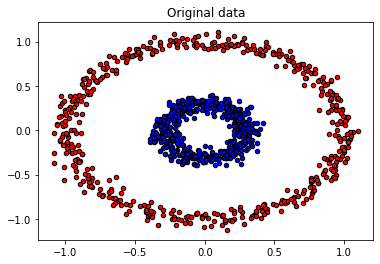

In [37]:
reds = y == 0
blues = y == 1
plt.scatter(X_train[reds, 0], X_train[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_train[blues, 0], X_train[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Original data")

In [31]:
gmm=GaussianMixture(max_iter=40,kernel="rbf",d_phi=[69,69],initial="random")

In [34]:
gmm.fit(cp.asarray(X_train))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Accuracy (0.732, array([0.76008969, 0.70938628]))
p_t-p_(t+1) 881.8276097651787
Accuracy (0.855, array([0.85858586, 0.85148515]))
p_t-p_(t+1) 257.82570683097384
Accuracy (0.955, array([0.91743119, 1.        ]))
p_t-p_(t+1) 200.0
Accuracy (0.996, array([0.99206349, 1.        ]))
p_t-p_(t+1) 82.0
Accuracy (1.0, array([1., 1.]))
p_t-p_(t+1) 8.0
Accuracy (1.0, array([1., 1.]))
p_t-p_(t+1) 2.5604915724335223e-41


In [39]:
label=cp.asnumpy(gmm.predict)

Text(0.5, 1.0, 'Clustering')

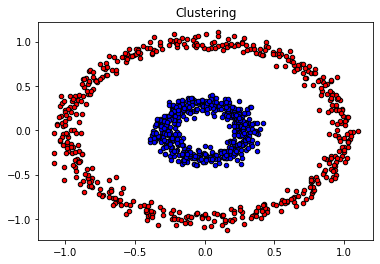

In [40]:
reds = label == 0
blues = label == 1
plt.scatter(X_train[reds, 0], X_train[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_train[blues, 0], X_train[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Clustering")